Text(0.5, 0.98, 'Normal Tempered Stable (NTS) Process')

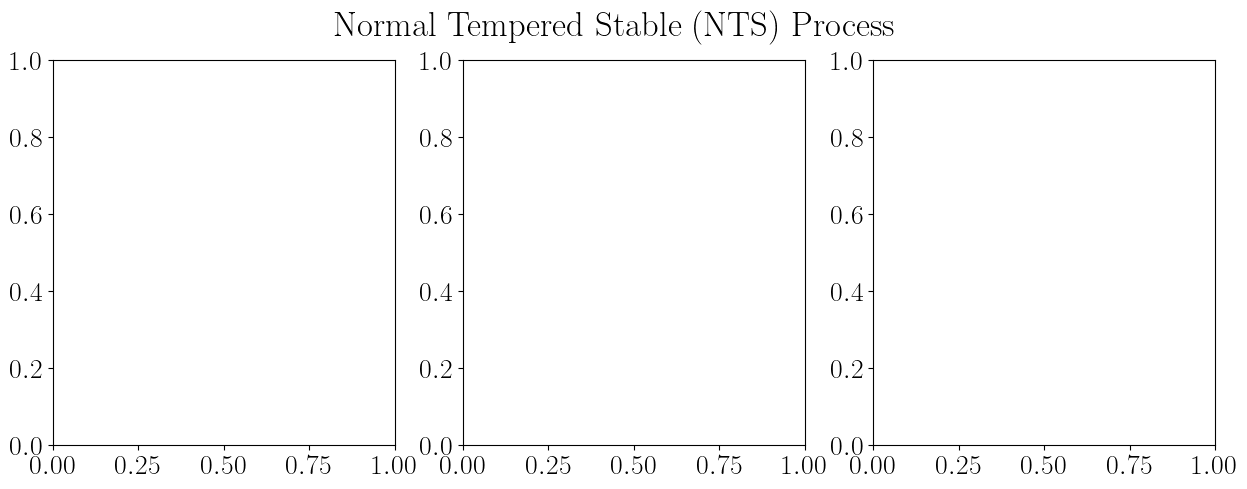

In [1]:
%load_ext autoreload
%autoreload 2

from utility import format_plt, symmetric_stable_scaling_factor, plot_tsnvm_residuals, save_fig, plot_tsnvm_process_1d
import matplotlib.pyplot as plt

font_size = 20
format_plt(font_size=font_size)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))  
fig.suptitle(r"Normal Tempered Stable (NTS) Process", fontsize=25)


In [12]:
from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState
from stonesoup.models.transition.driver import TemperedStableNVMDriver
from stonesoup.models.transition.driven import Process
from datetime import datetime, timedelta
from scipy.special import gamma as gammafnc
import numpy as np

# And the clock starts
start_time = datetime.now().replace(microsecond=0)
seed = 13
alpha = 0.4
gamma = 1.35
beta = (gamma ** (1 / alpha)) / 2.
print(f"{beta:.3f}")
noise_case=1
mu_W = 10
sigma_W2 = 1
# sigma_W2 = ((2 ** alpha) * alpha * (1 / gammafnc(1 - alpha))) ** 2
# print(sigma_W2)
# sigma_W2 = 1 / symmetric_stable_scaling_factor(alpha, 1)
# print(sigma_W2)
c= 50

ts_driver = TemperedStableNVMDriver(mu_W=mu_W, sigma_W2=sigma_W2, seed=seed, c=c, alpha=alpha, beta=beta, noise_case=noise_case)
transition_model = Process(cg_driver=ts_driver)


1.059


In [20]:
timesteps = [start_time]
truth = GroundTruthPath([GroundTruthState([0], timestamp=timesteps[0])])

num_steps = 10000
for k in range(1, num_steps + 1):
    timesteps.append(start_time+timedelta(seconds=k))  # add next timestep to list of timesteps
    truth.append(GroundTruthState(
        transition_model.function(truth[k-1], noise=True, time_interval=timedelta(seconds=1)),
        timestamp=timesteps[k]))

In [25]:
xtest = np.linspace(1, 10, 100)
# # xtest1 = np.linspace(-5, -0.5, 100)
# # xtest = np.concatenate((xtest1, xtest2))
pdf = ts_driver.pdf(xtest) 
print(pdf)
pdf = pdf.flatten()
# norm = np.trapz(pdf, xtest, axis=-1)
# # pdf /= norm
# # print(norm)
# print(norm)
# # pdf = (pdf) / pdf.std()
# # plt.hist(pdf, density=True, bins='auto')
# # plt.xlim((-3, 3))
# # plt.show()
# # print(x_test)

None


AttributeError: 'NoneType' object has no attribute 'flatten'

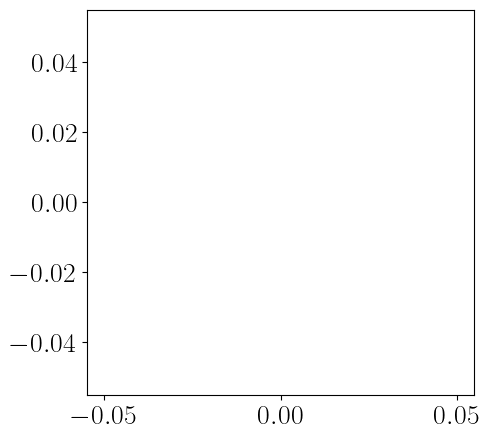

In [23]:
plt.plot(xtest, pdf)
y = np.diff([data.state_vector[0] for data in truth]) 
# y = (y) / y.std()

# plt.hist(y, density=True, bins='auto')
plt.show()

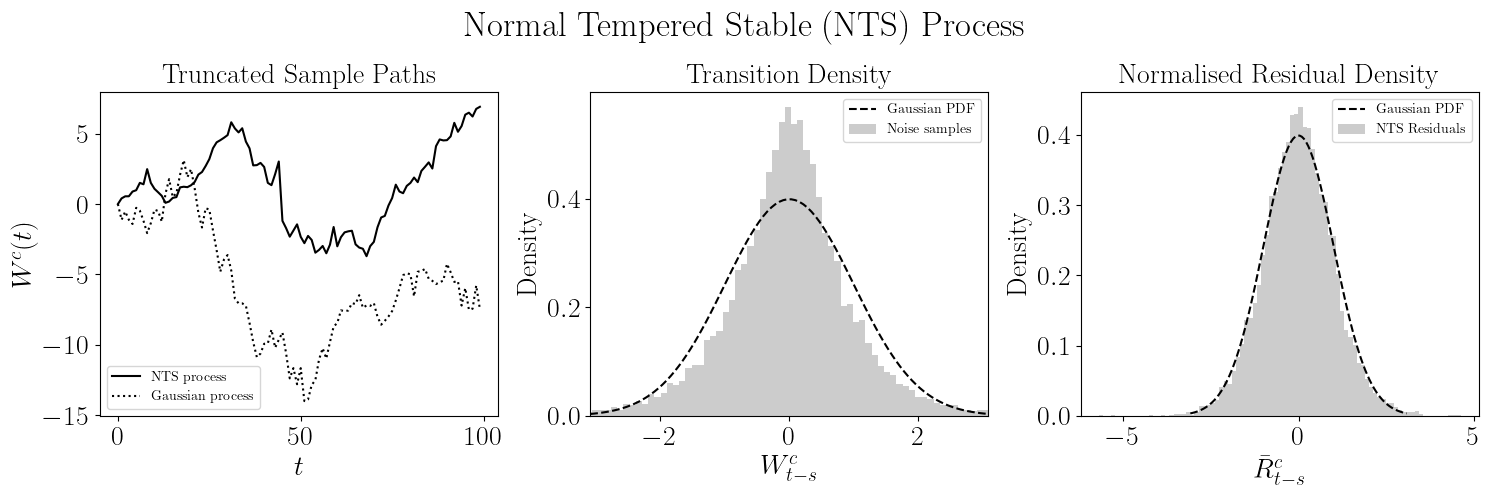

In [17]:
# title = r"Normal Tempered Stable (NTS) and Gaussian Process"
ax1.clear()
title = "Truncated Sample Paths"
xlabel = r"$t$"
ylabel = r"$W^c(t)$"
fig1 = plot_tsnvm_process_1d(fig, ax1, truth=truth[:100], sigma_W2=sigma_W2, title=title, xlabel=xlabel, ylabel=ylabel, beta=beta, alpha=alpha)
fig1

In [5]:
# save_fig(fig, "ts_process")

KS test p-value: 1.10261459428625e-24


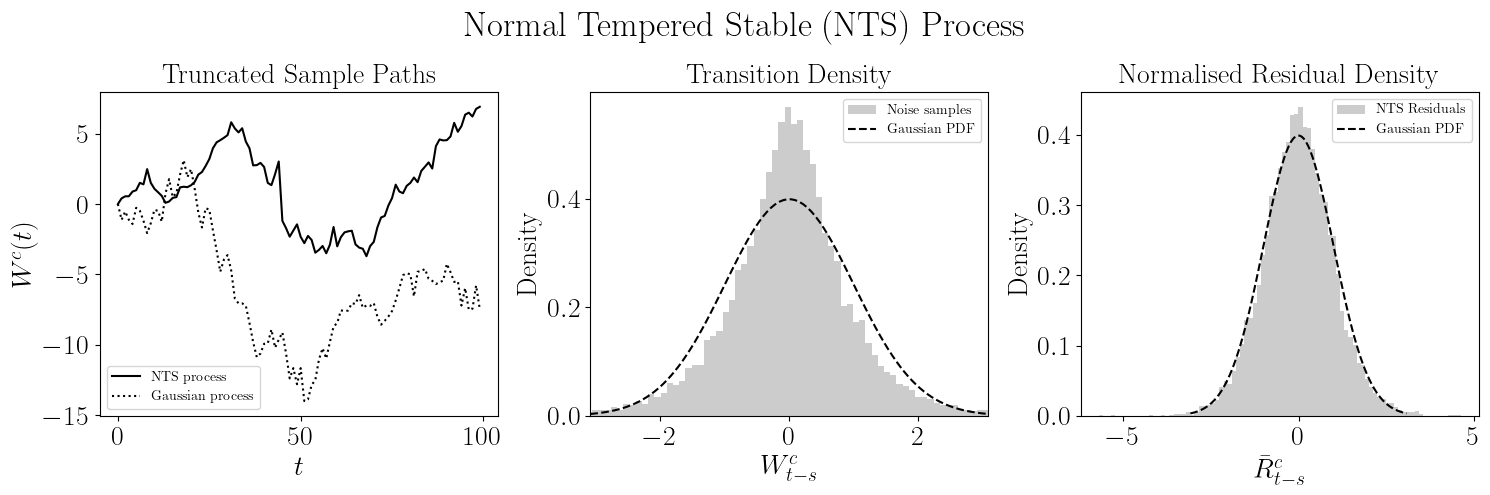

In [23]:
# title = r"NTS Process Transition Density"
ax2.clear()
xlabel = r"$W^c_{t-s}$"
ylabel = r"Density"
fig2 = plot_tsnvm_residuals(fig, ax2, truth=truth, title="Transition Density", xlabel=xlabel, ylabel=ylabel, sigma_W2=sigma_W2, alpha=alpha)
fig2

In [7]:
# save_fig(fig, "ts_transition_density")

KstestResult(statistic=0.014234724877195237, pvalue=0.03442444006700507, statistic_location=1.010053936283774, statistic_sign=1)


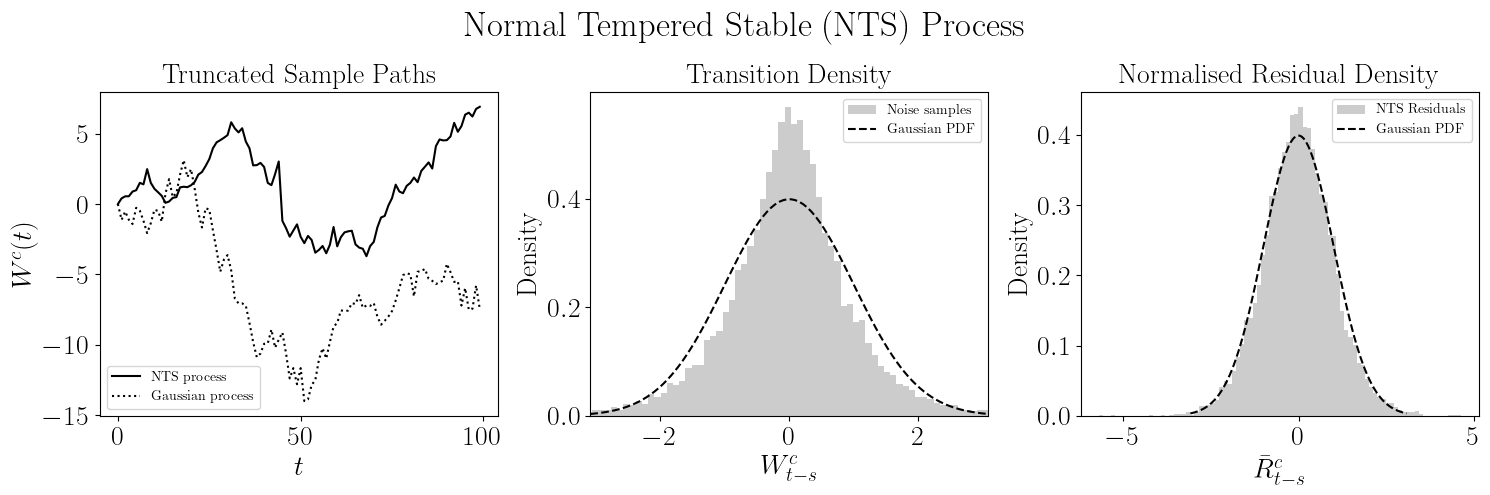

In [25]:
from stonesoup.models.transition.base_driver import Latents
import matplotlib.pyplot as plt
from scipy.stats import levy_stable, norm, kstest
# Investigate residuals

ax3.clear()
upper_limit = 100
nts = TemperedStableNVMDriver(mu_W=mu_W, sigma_W2=sigma_W2, seed=seed, c=upper_limit, alpha=alpha, beta=beta, noise_case=noise_case)
dt = 1
n_latents=10000
ft = lambda dt, jtimes: np.ones_like(jtimes)[..., None, None]
e_ft = lambda dt: dt * np.ones((1, 1))
sizes, times = nts.sample_latents(dt=dt, num_samples=n_latents)
residual_jsizes = sizes[c:]
residual_jtimes = times[c:]
latents = Latents(num_samples=n_latents)
latents.add(nts, residual_jsizes, residual_jtimes)

mean = nts.mean(e_ft_func=e_ft, ft_func=ft, dt=dt, latents=latents)
covar = nts.covar(e_ft_func=e_ft, ft_func=ft, dt=dt, latents=latents)
rvs = []
for i in range(n_latents):
    tmp = nts.rvs(e_ft_func=e_ft, ft_func=ft, dt=dt, latents=latents, covar=covar[i], mean=mean[i], num_samples=1)
    rvs.append(tmp[0])
y = np.array(rvs)
y = (y - y.mean()) / y.std()
results = kstest(y, norm.cdf, N=n_latents) 

x = np.linspace(norm.ppf(0.001), norm.ppf(0.999), 100)
# fig, ax = plt.subplots(nrows=1, ncols=1)  
ax3.hist(y, density=True, bins='auto', histtype='stepfilled', alpha=0.2, color='k', label='NTS Residuals')
ax3.plot(x, norm.pdf(x), '--', color='k', label='Gaussian PDF')    
ax3.set_title(r"Normalised Residual Density")
ax3.set_xlabel(r"$\bar R^c_{t-s}$")
ax3.set_ylabel(r"Density")
ax3.legend()
fig.tight_layout()
 
print(results)
fig

In [26]:
save_fig(fig, "ts_gathered")

In [20]:
# raise Exception

In [11]:
# from stonesoup.models.transition.base import CombinedLinearDrivenTransitionModel

# # And the clock starts
# start_time = datetime.now().replace(microsecond=0)
# seed = 1991

# mu_W = 0
# sigma_W2 = 2

# as_driver = AlphaStableNSMDriver(mu_W=mu_W, sigma_W2=sigma_W2, seed=seed, c=10, alpha=1.99)
# process_x = Process(cg_driver=as_driver)
# process_y = Process(cg_driver=as_driver)
# transition_model = CombinedLinearDrivenTransitionModel([process_x, process_y])


# timesteps = [start_time]
# truth = GroundTruthPath([GroundTruthState([0, 0], timestamp=timesteps[0])])

# num_steps = 1000
# for k in range(1, num_steps + 1):
#     timesteps.append(start_time+timedelta(seconds=k))  # add next timestep to list of timesteps
#     truth.append(GroundTruthState(
#         transition_model.function(truth[k-1], noise=True, time_interval=timedelta(seconds=1)),
#         timestamp=timesteps[k]))

In [12]:
# t = np.array([(data.timestamp - start_time).total_seconds() for data in truth])
# t -= t[0]
# y0 = np.array([data.state_vector[0] for data in truth])
# y1 = np.array([data.state_vector[1] for data in truth])

# fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1)

# ax1.plot(t, y0)
# ax2.plot(t, y1)

In [13]:
raise Exception

Exception: 

In [ ]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

def log_characteristic_function(u, alpha, lambda_, c):
    """
    Logarithm of the characteristic function of a tempered stable distribution.
    
    Parameters:
    u : float or array-like
        The argument of the characteristic function.
    alpha : float
        The stability parameter (0 < alpha < 2).
    lambda_ : float
        The tempering parameter (lambda_ > 0).
    c : float
        The scale parameter.
    
    Returns:
    log_cf : complex or array-like
        The logarithm of the characteristic function evaluated at u.
    """
    term = (lambda_ - 1j * u) ** alpha
    log_cf = -c * (term - lambda_ ** alpha)
    return log_cf

def characteristic_function(u, alpha, lambda_, c):
    """
    Characteristic function of a tempered stable distribution.
    
    Parameters:
    u : float or array-like
        The argument of the characteristic function.
    alpha : float
        The stability parameter (0 < alpha < 2).
    lambda_ : float
        The tempering parameter (lambda_ > 0).
    c : float
        The scale parameter.
    
    Returns:
    cf : complex or array-like
        The characteristic function evaluated at u.
    """
    log_cf = log_characteristic_function(u, alpha, lambda_, c)
    return np.exp(log_cf)

def pdf_tempered_stable(x, alpha, lambda_, c):
    """
    PDF of a symmetric tempered stable distribution using numerical integration.
    
    Parameters:
    x : float or array-like
        The point(s) at which the PDF is evaluated.
    alpha : float
        The stability parameter (0 < alpha < 2).
    lambda_ : float
        The tempering parameter (lambda_ > 0).
    c : float
        The scale parameter.
    
    Returns:
    pdf : float or array-like
        The PDF evaluated at x.
    """
    def integrand(u, x):
        cf = characteristic_function(u, alpha, lambda_, c)
        return np.real(cf * np.exp(-1j * u * x))
    
    pdf_values = []
    for xi in np.atleast_1d(x):
        integral, _ = integrate.quad(integrand, -100, 100, args=(xi,), limit=100)
        pdf_values.append(integral / (2 * np.pi))
    
    return np.array(pdf_values)

# Parameters
alpha = 1.5
lambda_ = 1.0
c = 1.0

# Points at which to evaluate the PDF
x = np.linspace(-10, 10, 1000)

# Compute the PDF
pdf_values = pdf_tempered_stable(x, alpha, lambda_, c)

# Plot the PDF
plt.figure(figsize=(8, 6))
plt.plot(x, pdf_values, label='Tempered Stable PDF')
plt.title('PDF of the Tempered Stable Distribution')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()
